In [1]:
import sys
import yaml

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

sys.path.append('../src')
sys.path.append('../../../utils')

from unet import Unet
from isbi_em_dataset import ISBIEMDataset

from eval_utils import evaluate_model, get_pixel_accuracy
from train_utils import he_init, get_distribution, Trainer, OptimizerFactory

/home/kramasamy/.venv/globalenv/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.22). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2024-12-22 09:07:36.960912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734838656.977872   10188 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734838656.982917   10188 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-22 09:07:37.000267: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow

In [2]:
# Load config.
with open('../configs/train_pretrained_config.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

# Load dataset.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.4945, 0.1715)
])
DATA_DIR = '/home/kramasamy/Code/projects/cnn/data/isbi_em_segmentation'
train_dataset = ISBIEMDataset(DATA_DIR, transform=transform, train=True)
test_dataset = ISBIEMDataset(DATA_DIR, transform=transform, train=False)

In [3]:
get_distribution(train_dataset)

(tensor(-0.0002), tensor(0.9984))

In [4]:
##Load model.
# Get dataset class frequency. 

In [5]:
import pickle as pkl
pretrain_unet_result = pkl.load(open('../checkpoints/pretrain_unet_results.pkl', 'rb'))
pretrained_unet = pretrain_unet_result['model'].unet

In [6]:
model = Unet()
model.apply(he_init)
model.load_state_dict(pretrained_unet.state_dict())

# Custom optimizer.
encoder_params = list(model.block1.parameters()) + \
                 list(model.block2.parameters()) + \
                 list(model.block3.parameters()) + \
                 list(model.block4.parameters()) + \
                 list(model.block5.parameters())

decoder_params = list(model.block6.parameters()) + \
                 list(model.block7.parameters()) + \
                 list(model.block8.parameters()) + \
                 list(model.block9.parameters()) + \
                 list(model.final_conv.parameters())

optimizer_factory = OptimizerFactory(config['optimizer'])
lr = config['optimizer']['params']['lr']
del config['optimizer']['params']['lr']
optimizer = optimizer_factory.get_optimizer([
    {'params': encoder_params, 'lr': lr * config['optimizer']['lr_damp_pretrained']},  
    {'params': decoder_params, 'lr': lr}   # Larger LR for decoder
])

In [7]:
# Load model.
torch.cuda.empty_cache()
model.to('cuda')
trainer = Trainer(model, train_dataset, config)
result = trainer.train(optimizer=optimizer, print_loss=True)

tensor([0.7794, 0.2206])
Get loss fn with weighted loss.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Loss: 0.5057052781184515


  5%|▌         | 1/20 [03:00<57:13, 180.73s/it]

Epoch 2/20, Loss: 0.4024291917681694


 10%|█         | 2/20 [07:18<1:07:49, 226.08s/it]

Epoch 3/20, Loss: 0.41149688760439557


 15%|█▌        | 3/20 [11:39<1:08:31, 241.88s/it]

Epoch 4/20, Loss: 0.39111709197362265


 20%|██        | 4/20 [16:00<1:06:29, 249.36s/it]

Epoch 5/20, Loss: 0.3609193076690038


 25%|██▌       | 5/20 [20:17<1:03:04, 252.31s/it]

Epoch 6/20, Loss: 0.37457477003335954


 30%|███       | 6/20 [24:35<59:17, 254.10s/it]  

Epoch 7/20, Loss: 0.3442329968015353


 35%|███▌      | 7/20 [28:56<55:32, 256.33s/it]

Epoch 8/20, Loss: 0.3350410684943199


 40%|████      | 8/20 [33:24<52:03, 260.27s/it]

Epoch 9/20, Loss: 0.3301950767636299


 45%|████▌     | 9/20 [37:51<48:05, 262.28s/it]

Epoch 10/20, Loss: 0.3265049035350482


 50%|█████     | 10/20 [42:15<43:47, 262.74s/it]

Epoch 11/20, Loss: 0.3227236017584801


 55%|█████▌    | 11/20 [46:37<39:24, 262.67s/it]

Epoch 12/20, Loss: 0.32350263049205147


 60%|██████    | 12/20 [51:02<35:07, 263.44s/it]

Epoch 13/20, Loss: 0.32164414872725805


 65%|██████▌   | 13/20 [55:25<30:42, 263.25s/it]

Epoch 14/20, Loss: 0.31920344283183416


 70%|███████   | 14/20 [59:48<26:17, 262.94s/it]

Epoch 15/20, Loss: 0.3183498571316401


 75%|███████▌  | 15/20 [1:04:11<21:55, 263.17s/it]

Epoch 16/20, Loss: 0.31601168364286425


 80%|████████  | 16/20 [1:08:34<17:32, 263.15s/it]

Epoch 17/20, Loss: 0.31508547614018123


 85%|████████▌ | 17/20 [1:12:57<13:09, 263.14s/it]

Epoch 18/20, Loss: 0.3143599991997083


 90%|█████████ | 18/20 [1:17:20<08:46, 263.03s/it]

Epoch 19/20, Loss: 0.3147479876875877


 95%|█████████▌| 19/20 [1:21:42<04:22, 262.60s/it]

Epoch 20/20, Loss: 0.3139564101894697


100%|██████████| 20/20 [1:26:02<00:00, 258.11s/it]


In [8]:
import pickle as pkl
pkl.dump(result, open('../logs/train_pretrained_unet.pkl', 'wb'))

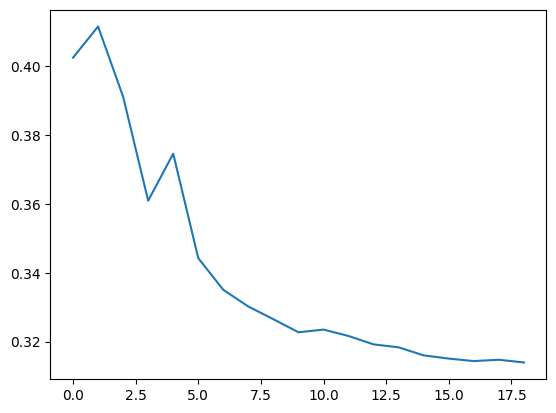

In [9]:
import matplotlib.pyplot as plt

plt.plot(result['loss_history'][1:])

In [10]:
torch.cuda.empty_cache()
train_loader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
y_pred_train, y_true_train = evaluate_model(model, train_loader)
y_pred_test, y_true_test = evaluate_model(model, test_loader)

In [11]:
print(get_pixel_accuracy(y_pred_train, y_true_train))
print(get_pixel_accuracy(y_pred_test, y_true_test))


84.74700164794922
84.71505737304688


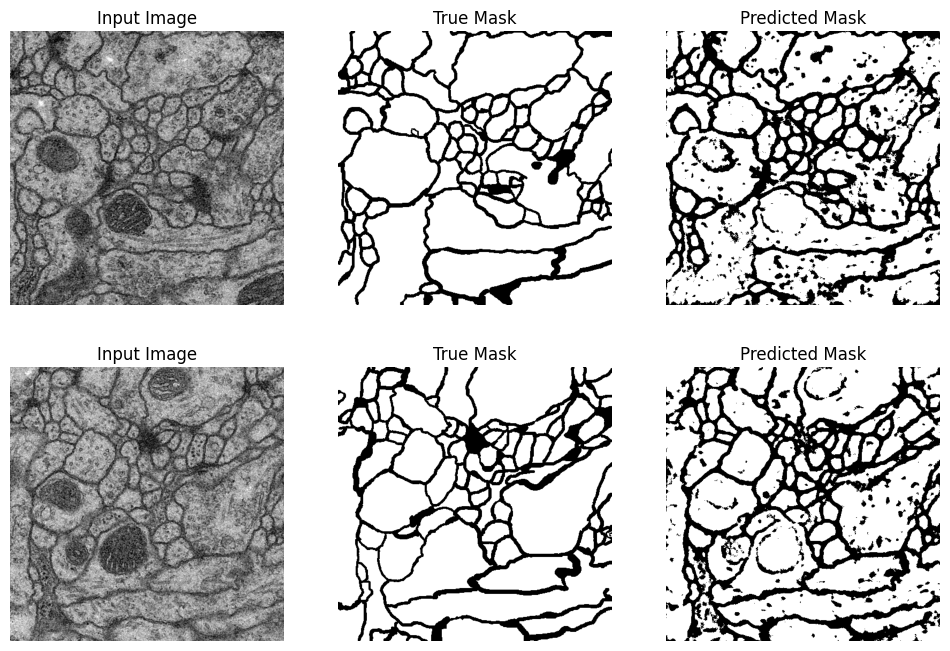

In [14]:
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Subset

n = 2 # Number to sample to examine.

random_indices = random.sample(range(len(test_dataset)), n)
random_subset = Subset(train_dataset, random_indices)
random_test_dataloader = DataLoader(random_subset, batch_size=2)
y_pred_logits, y_true = evaluate_model(model, random_test_dataloader)


fig, axes = plt.subplots(n, 3, figsize=(12, 4 * n))

for i in range(n):
    img = random_subset[i][0]
    # Plot input image (assuming the image has 3 channels or grayscale)
    axes[i, 0].imshow(img.squeeze().to('cpu'), cmap='gray')
    axes[i, 0].set_title("Input Image")
    axes[i, 0].axis('off')

    # Plot true mask
    axes[i, 1].imshow(y_true[i].to('cpu'), cmap='gray')
    axes[i, 1].set_title("True Mask")
    axes[i, 1].axis('off')

    # Plot predicted mask
    y_probs = F.softmax(y_pred_logits[i], dim=0)
    y_pred = torch.argmax(y_probs, dim=0)
    axes[i, 2].imshow(y_pred.to('cpu'), cmap='gray')
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis('off')

In [4]:
import pickle as pkl
import matplotlib.pyplot as plt
trained_pretrained_unet = pkl.load(open('../logs/train_pretrained_unet.pkl', 'rb'))
trained_unet = pkl.load(open('../logs/train_unet.pkl', 'rb'))

# fig, ax = plt